# Issues and solutions

This notebook is for solving reported issues here: https://github.com/hcp4715/dockerHDDM/issues

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current kabuki version is:  0.6.4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.12.0


In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

In [3]:
data_cavanagh = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
data_cavanagh.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


## Fixing issue 2 [solved]
https://github.com/hcp4715/dockerHDDM/issues/2

I use the example data, `data_cavanagh`, to test the function.

The problem was caused by "out of memory".

The testing codes were commented.

In [4]:
# def ms1_1(id, df=None, samples=None, burn=None, thin=1, save_name="ms1_1_tmp"): 
#     print('running chain {:d} for model {}'.format(id, save_name))
#     import hddm
    
#     dbname = save_name + '_chain_%i.db'%id 
#     mname  = save_name + '_chain_%i'%id   
#     m = hddm.HDDMRegressor(df,  
#                            "v ~ C(dbs, Treatment(0))", # I changed the variable name to dbs in the example data.
#                            group_only_regressors=True,
#                            keep_regressor_trace=True)
#     m.find_starting_values()
#     m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
#     m.save(mname)
    
#     return m

# %%time

# chains = 4

# file_names = glob.glob("ms1_1_tmp" + "_chain_*[!db]", recursive=False)

# if file_names:
#     file_names = sorted(file_names, key=lambda x: x[-1]) # sort filenames by chain ID
#     ms1_1res = []
#     for fname in file_names:
#         print('current loading: ', fname, '\n')
#         ms4res.append(hddm.load(fname))
# else:
#     ms1_1res = p_map(partial(ms1_1, df=data_cavanagh, samples=200, burn=100, save_name="ms1_1_tmp"), range(chains))
    

# %%time
# InfData_ms1_1 = InferenceDataFromHDDM(ms1_1res, nppc = 10, save_name="ms1_1_tmp")

# az.plot_trace(InfData_ms1_1)

## Fixing issue 3

https://github.com/hcp4715/dockerHDDM/issues/3

In [5]:
def ms1_issue3(id, df=None, samples=None, burn=None, thin=1, save_name="ms1_issue3"):
    print("running chian {:d} for model {}".format(id, save_name))
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    v_reg = {'model': 'v~1', 'link_func': lambda x:x}
    z_reg = {'model': 'z~1', 'link_func': lambda x:x}
    t_reg = {'model': 't~1', 'link_func': lambda x:x}
    a_reg = {'model': 'a~1', 'link_func': lambda x:x}
    
    reg_descr = [v_reg,
                z_reg,
                t_reg,
                a_reg]
    
    m = hddm.HDDMRegressor(df, 
                           reg_descr,
                           include=['z'], 
                           group_only_regressors=False,
                           keep_regressor_trace=True
                          )
    
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

In [6]:
%%time

chains = 1

file_names = glob.glob("ms1_issue3" + "_chain_*[!db]", recursive=False)

if file_names:
    file_names = sorted(file_names, key=lambda x: x[-1]) # sort filenames by chain ID
    msi3res = []
    for fname in file_names:
        print('current loading: ', fname, '\n')
        msi3res.append(hddm.load(fname))
else:
    msi3res = p_map(partial(ms1_issue3, 
                            df=data_cavanagh, 
                            samples=100, 
                            burn=10, save_name="ms1_issue3"), range(chains))

running chian 0 for model ms1_issue3

  0%|          | 0/1 [00:00<?, ?it/s]


Adding these covariates:
['v_Intercept']
Adding these covariates:
['z_Intercept']
Adding these covariates:
['t_Intercept']
Adding these covariates:
['a_Intercept']


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  2%                  ] 2 of 100 complete in 0.7 sec[-                 3%                  ] 3 of 100 complete in 1.2 sec[-                 5%                  ] 5 of 100 complete in 2.2 sec[--                6%                  ] 6 of 100 complete in 2.7 sec[---               8%                  ] 8 of 100 complete in 3.5 sec[---              10%                  ] 10 of 100 complete in 4.5 sec[----             12%                  ] 12 of 100 complete in 5.4 sec[-----            14%                  ] 14 of 100 complete in 6.3 sec[------           16%                  ] 16 of 100 complete in 7.2 sec[------           18%                  ] 18 of 100 complete in 8.1 sec[-------          20%                  ] 20 of 100 complete in 9.1 sec[-------          21%                  ] 21 of 100 complete in 9.6 sec[--------         22%                  ] 22 of 100 complete in 10.1 sec[---------        24%                  ] 24 of 100 complete in 11.2 sec[---------        26% 

In [7]:
msi3res

In [8]:
InfData_msi3 = InferenceDataFromHDDM(msi3res, nppc = 10, save_name = "msi3res")

start converting msi3res


  0%|          | 0/1 [00:00<?, ?it/s]

started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 10.6 sec[-------------    35%                  ] 5 of 14 complete in 20.7 sec[---------------- 42%                  ] 6 of 14 complete in 30.4 sec[-----------------50%                  ] 7 of 14 complete in 39.2 sec[-----------------57%-                 ] 8 of 14 complete in 48.3 sec[-----------------64%----              ] 9 of 14 complete in 58.3 sec[-----------------71%-------           ] 10 of 14 complete in 68.0 sec[-----------------78%---------         ] 11 of 14 complete in 78.0 sec[-----------------85%------------      ] 12 of 14 complete in 88.2 sec[-----------------92%---------------   ] 13 of 14 complete in 95.8 sec[-----------------100%-----------------] 14 of 14 complete in 106.5 sec[------------------107%------------------] 15 of 14 complete in 117.1 sec[-------------------114%--------------------] 16 of 14 complete in 126.1 sec[---------------------121%-----------------

  0%|          | 0/1 [00:00<?, ?it/s]

started to generate posterior predicitves
 [----------       28%                  ] 4 of 14 complete in 7.1 sec[-------------    35%                  ] 5 of 14 complete in 14.3 sec[---------------- 42%                  ] 6 of 14 complete in 21.1 sec[-----------------50%                  ] 7 of 14 complete in 27.0 sec[-----------------57%-                 ] 8 of 14 complete in 33.9 sec[-----------------64%----              ] 9 of 14 complete in 40.9 sec[-----------------71%-------           ] 10 of 14 complete in 47.9 sec[-----------------78%---------         ] 11 of 14 complete in 54.8 sec[-----------------85%------------      ] 12 of 14 complete in 61.5 sec[-----------------92%---------------   ] 13 of 14 complete in 66.6 sec[-----------------100%-----------------] 14 of 14 complete in 73.9 sec[------------------107%------------------] 15 of 14 complete in 80.9 sec[-------------------114%--------------------] 16 of 14 complete in 87.3 sec[---------------------121%---------------------

array([[<AxesSubplot:title={'center':'v_Intercept'}>,
        <AxesSubplot:title={'center':'v_Intercept'}>],
       [<AxesSubplot:title={'center':'v_Intercept_std'}>,
        <AxesSubplot:title={'center':'v_Intercept_std'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.0'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.0'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.1'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.1'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.2'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.2'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.3'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.3'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.4'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.4'}>],
       [<AxesSubplot:title={'center':'v_Intercept_subj.5'}>,
        <AxesSubplot:title={'center':'v_Intercept_subj.5'}>],
       [<AxesSubplot:title={'center'

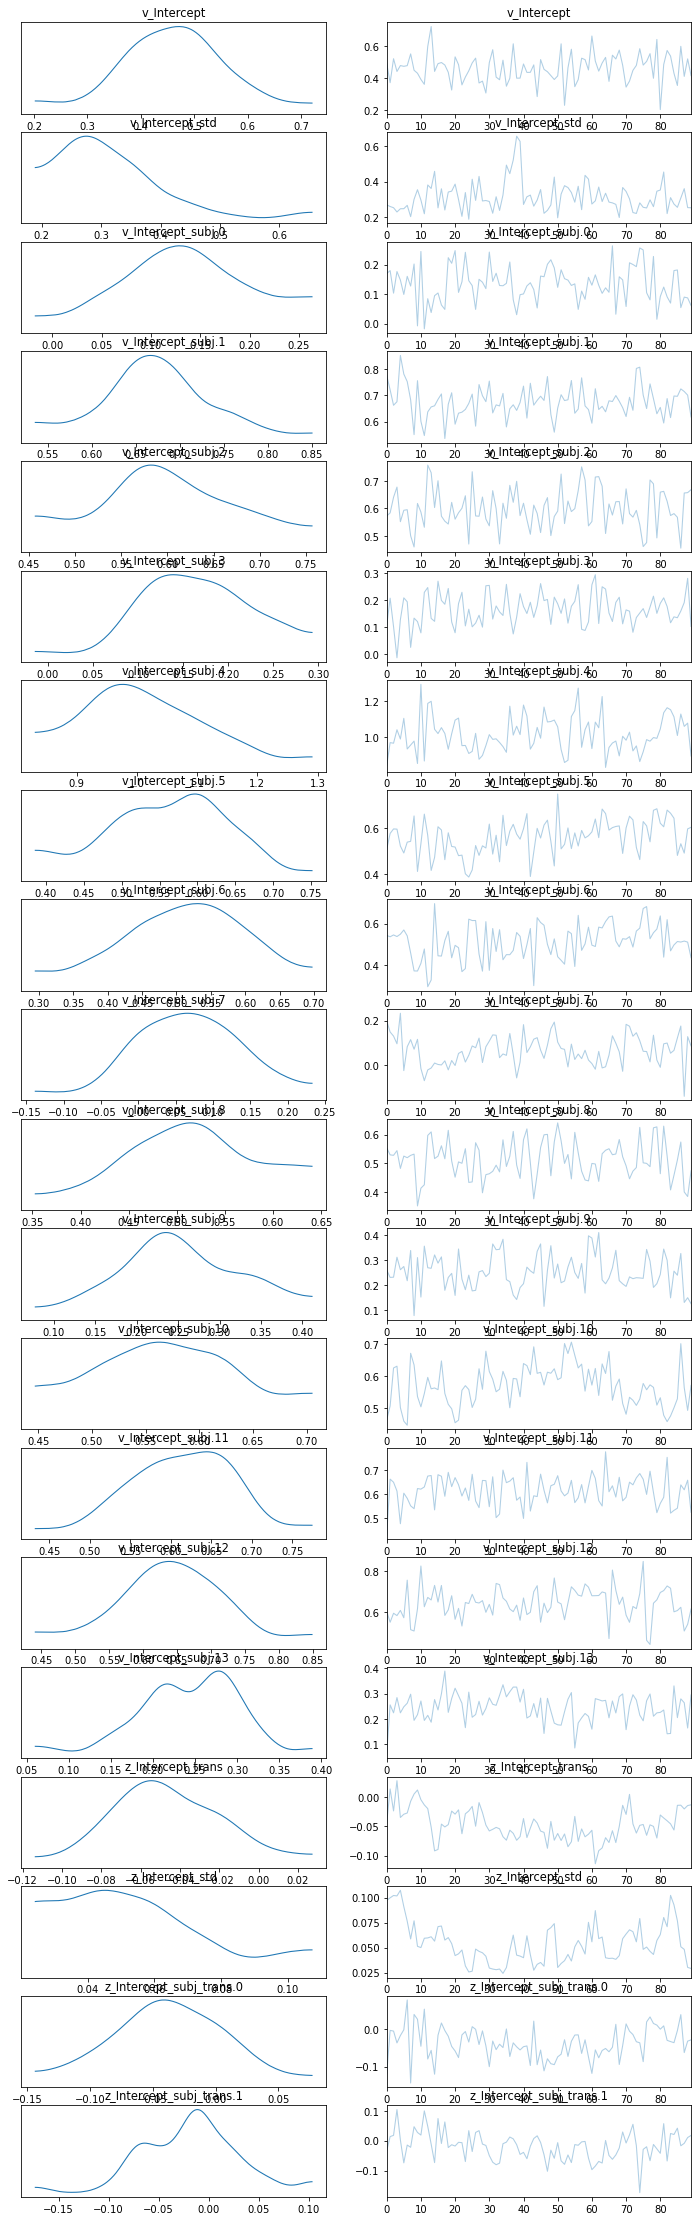

In [9]:
az.plot_trace(InfData_msi3)